# UNIDADE 1: Inteligência Artificial

1.1. Fundamentos do Aprendizado de Máquina  
1.2. Tipos de Tarefas de Aprendizado  
  1.2.1. Supervisionado  
  1.2.2. Não supervisionado  
  1.2.3. Semi supervisionado  
  1.2.4. Aprendizado por reforço  
1.3. Modelagem preditiva  

<div style="border: 2px solid #00008B; padding: 15px; border-radius: 10px; background-color: #00008B; color: #FFFFFF; font-family: Arial;">
  <h1 style="margin-top: 0;">Prática: Classificação de casos de Alzheimer</h1>

A escala clínica usada para avaliar o estágio de gravidade da demência em pacientes: demência muito leve, demência leve, demência moderada, além de sem demência

Baseado em: https://www.kaggle.com/code/danttis/alzheimer-s-classification-using-knn/notebook

</div>

<div style="background-color: #f0f8ff; padding: 20px; border-radius: 10px;">
  <ul>
    <li>ID (identificação)</li> 
    <li>Sexo (M/F)</li> 
    <li>Mão dominante (Hand)</li> 
    <li>Idade (Age)</li> 
    <li>Nível de educação (Edu)</li> 
    <li>Status socioeconômico (SES)</li> 
    <li>Pontuação no Mini-Mental State Examination (MMSE) que avalia a função cognitiva</li> 
    <li>Classificação do Clinical Dementia Rating (CDR) que indica o estágio de gravidade da demência</li> 
    <li>Volume total do cérebro e do crânio (eTIV)</li> 
    <li>Volume Cerebral Total Normalizado (nWBV) que mede o volume cerebral relativo ao tamanho total do cérebro</li> 
    <li>Valor único do tamanho relativo do cérebro em relação a um atlas padrão (ASF)</li> 
    <li>Atraso (Delay), medido em meses, entre a aquisição das imagens cerebrais e a avaliação clínica ou cognitiva dos participantes</li>
  </ul>
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
from IPython.display import Image
import matplotlib.pyplot as plt

# Gerando dados fictícios

In [3]:
data = {
    'ID': range(1, 21),
    'Sexo': ['M', 'F', 'M', 'F', 'M', 'F', 'M', 'F', 'M', 'F', 'M', 'F', 'M', 'F', 'M', 'F', 'M', 'F', 'M', 'F'],
    'Mão Dominante': ['D', 'E', 'D', 'D', 'E', 'D', 'E', 'D', 'D', 'E', 'D', 'D', 'E', 'D', 'E', 'D', 'D', 'E', 'D', 'D'],
    'Idade': [75, 80, 65, 70, 85, 60, 77, 82, 67, 72, 88, 62, 74, 68, 81, 73, 66, 78, 79, 64],
    'Nível de Educação': [12, 16, 14, 10, 18, 13, 15, 12, 16, 11, 17, 14, 13, 15, 11, 12, 13, 14, 15, 16],
    'Status Socioeconômico': [3, 4, 2, 1, 5, 3, 4, 2, 1, 5, 3, 4, 2, 1, 5, 3, 4, 2, 1, 5],
    'MMSE': [25, 30, 40, 24, 28, 26, 31, 39, 23, 29, 27, 32, 38, 22, 28, 24, 31, 37, 21, 26],
    'eTIV': [1500, 1600, 1950, 1480, 1570, 1500, 1600, 1950, 1480, 1570, 1500, 1600, 1950, 1480, 1570, 1500, 1600, 1950, 1480, 1570],
    'nWBV': [0.68, 0.70, 0.86, 0.65, 0.69, 0.68, 0.70, 0.86, 0.65, 0.69, 0.68, 0.70, 0.86, 0.65, 0.69, 0.68, 0.70, 0.86, 0.65, 0.69],
    'ASF': [1.2, 1.1, 1.9, 1.2, 1.1, 1.2, 1.1, 1.9, 1.2, 1.1, 1.2, 1.1, 1.9, 1.2, 1.1, 1.2, 1.1, 1.9, 1.2, 1.1],
    'Delay': [0, 2, 1, 3, 4, 0, 2, 1, 3, 4, 0, 2, 1, 3, 4, 0, 2, 1, 3, 4],
    'CDR': ['DML', 'SD', 'DML', 'DL', 'DML', 'DL', 'SD', 'DL', 'DML', 'DML', 'DL', 'SD', 'DML', 'DL', 'DML', 'DML', 'DL', 'SD', 'DML', 'DML']
}

df = pd.DataFrame(data)
df.head()

,ID,Sexo,Mão Dominante,Idade,Nível de Educação,Status Socioeconômico,MMSE,eTIV,nWBV,ASF,Delay,CDR
0,1,M,D,75,12,3,25,1500,0.68,1.2,0,DML
1,2,F,E,80,16,4,30,1600,0.70,1.1,2,SD
2,3,M,D,65,14,2,40,1950,0.86,1.9,1,DML
3,4,F,D,70,10,1,24,1480,0.65,1.2,3,DL
4,5,M,E,85,18,5,28,1570,0.69,1.1,4,DML


# Preparando os dados

In [4]:
# Convertendo Sexo e Mão Dominante para códigos numéricos
df['Sexo'] = df['Sexo'].astype('category').cat.codes
df['Mão Dominante'] = df['Mão Dominante'].astype('category').cat.codes

In [5]:
# Separando features e target
X = df[['Sexo', 'Mão Dominante', 'Idade', 'Nível de Educação', 'Status Socioeconômico', 'MMSE', 'eTIV', 'nWBV', 'ASF', 'Delay']]
y = df['CDR']

# Dividindo os dados em treino e teste

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Supervisionado

### Nearest Neighbors (KNN)

<div style="background-color: #f0f8ff; padding: 20px; border-radius: 10px;">
KNN é um algoritmo de aprendizado supervisionado usado para classificação e regressão. Ele funciona ao classificar uma nova amostra com base nas <b>classes dos seus k vizinhos mais próximos</b>. A classe mais comum entre os k vizinhos é atribuída à nova amostra. A distância entre os pontos pode ser calculada usando diferentes métricas, como a distância Euclidiana.
</div>

<img src="images/knn.png" alt="Silhouette Score" width="500" height="200" />

In [7]:
# Instanciando o modelo knn
knn = KNeighborsClassifier(n_neighbors=3)

In [8]:
# Treinando o modelo com a base de treinamento
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [9]:
# Fazendo predições com a base de teste
knn_predictions = knn.predict(X_test)

In [10]:
# Calculando a acurácia do KNN
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("Acurácia do KNN:", knn_accuracy)

Acurácia do KNN: 0.25


In [15]:
# Fazendo a previsão


### Árvore de Decisão (Decision Tree)

<div style="background-color: #f0f8ff; padding: 20px; border-radius: 10px;">
As Árvores de Decisão são modelos de aprendizado supervisionado que usam uma estrutura de árvore para tomar decisões baseadas nos valores dos atributos. Elas são usadas tanto para classificação quanto para regressão. O modelo <b>divide o espaço de atributos em regiões recursivamente</b>, tomando decisões baseadas na maximização da pureza das folhas (nós terminais).
</div>

<img src="images/tree2.png" alt="Silhouette Score" width="400" height="200" />
<img src="images/tree1.png" alt="Silhouette Score" width="400" height="200" />

In [16]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
tree_predictions = tree.predict(X_test)

In [17]:
# Calculando a acurácia da árvore de decisão
tree_accuracy = accuracy_score(y_test, tree_predictions)
print("Acurácia da Árvore de Decisão:", tree_accuracy)

Acurácia da Árvore de Decisão: 0.25


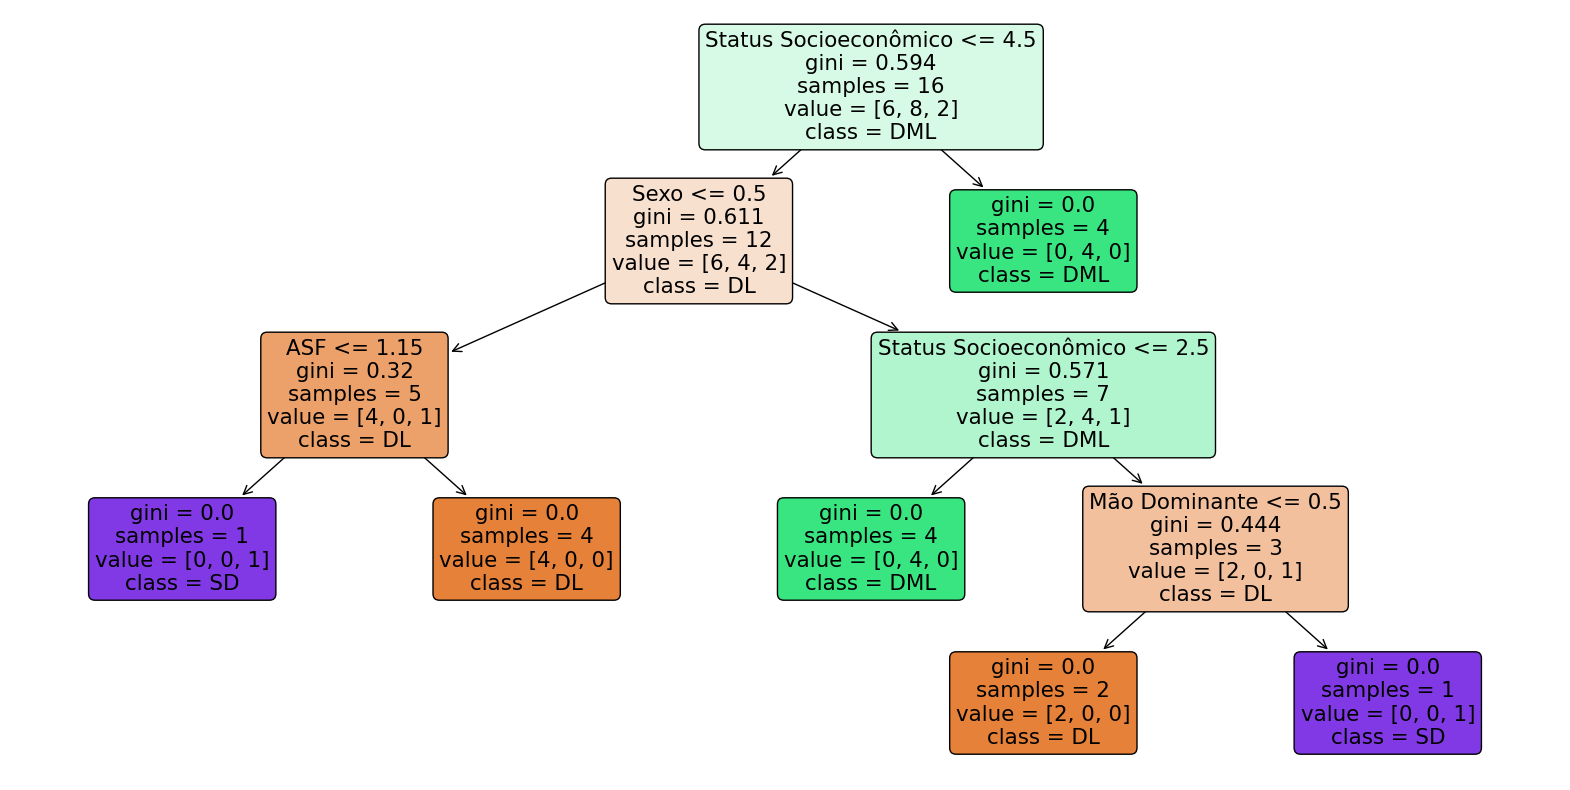

In [18]:
# Visualizando a árvore de decisão
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=list(X.columns), class_names=list(tree.classes_), filled=True, rounded=True)
plt.show()

In [20]:
# Fazendo a previsão


### Support Vector Machine

<div style="background-color: #f0f8ff; padding: 20px; border-radius: 10px;">
SVM é um algoritmo de aprendizado supervisionado usado para classificação e regressão. Ele encontra um hiperplano que melhor separa as classes no espaço dos atributos.SVM tenta <b>maximizar a margem entre as classes</b>. Em casos <b>não linearmente separáveis, usa-se o truque do kernel para mapear os dados</b> para um espaço de maior dimensão onde se tornem separáveis.
</div>

<img src="images/svm1.png" alt="Silhouette Score" width="500" height="200" />
<img src="images/svm2.png" alt="Silhouette Score" width="500" height="200" />

In [21]:
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
svm_predictions = svm.predict(X_test)

In [22]:
# Calculando a acurácia do SVM
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("Acurácia do SVM:", svm_accuracy)

Acurácia do SVM: 0.25


In [24]:
# Fazendo previsão


# Não Supervisionado

### KMeans Clustering

<div style="background-color: #f0f8ff; padding: 20px; border-radius: 10px;">
K-Means é um algoritmo de aprendizado não supervisionado usado para agrupar dados em k clusters baseados em suas características. O algoritmo <b>atribui iterativamente cada ponto de dados ao cluster mais próximo, recalculando os centróides</b> até que a convergência seja alcançada.
</div>

<img src="images/kmeans.png" alt="Silhouette Score" width="500" height="200" />

Observe que **NÃO** é passado um conjunto **TARGET** para o algoritmo não supervisionado.

In [25]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)
clusters = kmeans.predict(X)

Como KMeans é um algoritmo de clustering, você **não pode usar diretamente a métrica de acurácia, pois não há rótulos verdadeiros para comparar**. No entanto, você pode avaliar a qualidade dos clusters usando métricas como o **Silhouette Score** ou **Davies-Bouldin Score**.

O Silhouette Score mede a **similaridade de um ponto INDIVIDUALMETE com outros pontos no mesmo cluster (coesão) em comparação com pontos em clusters diferentes (separação)**. Um Silhouette Score alto (próximo de 1) indica que os clusters são bem definidos.

<img src="images/silhouette.png" alt="Silhouette Score" width="300" height="100" />

Davies-Bouldin Score mede a **relação entre a coesão (compacidade) de um CLUSTER e a separação entre clusters**.  Um Davies-Bouldin Score mais baixo indica clusters mais compactos e bem separados, o que implica uma melhor qualidade dos clusters.

<img src="images/davies-bouldin.png" alt="Silhouette Score" width="300" height="100" />


In [26]:
# Calculando o Silhouette Score
kmeans_silhouette = silhouette_score(X, clusters)
print("Silhouette Score do KMeans:", kmeans_silhouette)

Silhouette Score do KMeans: 0.7507379156425191


In [27]:
# Calculando o Davies-Bouldin Score
kmeans_davies_bouldin = davies_bouldin_score(X, clusters)
print("Davies-Bouldin Score do KMeans:", kmeans_davies_bouldin)

Davies-Bouldin Score do KMeans: 0.3333532952264354


In [29]:
# Fazendo a previsão


Previsão para o novo exemplo: [3]


In [30]:
# Adicionando a coluna CDR_cluster ao dataframe
X['CDR_cluster'] = clusters
X.head()

,ID,Sexo,Mão Dominante,Idade,Nível de Educação,Status Socioeconômico,MMSE,eTIV,nWBV,ASF,Delay,CDR,CDR_cluster
0,1,1,0,75,12,3,25,1500,0.68,1.2,0,DML,2
1,2,0,1,80,16,4,30,1600,0.70,1.1,2,SD,3
2,3,1,0,65,14,2,40,1950,0.86,1.9,1,DML,0
3,4,0,0,70,10,1,24,1480,0.65,1.2,3,DL,2
4,5,1,1,85,18,5,28,1570,0.69,1.1,4,DML,1


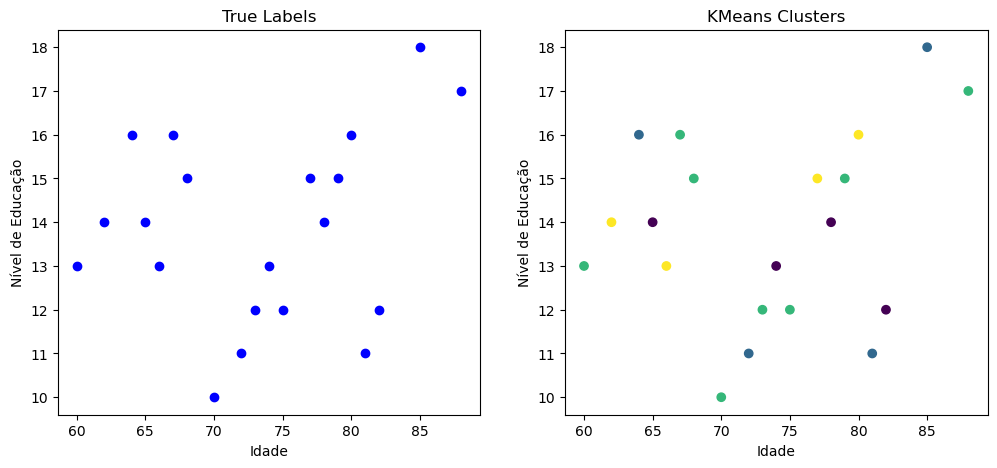

In [31]:
# Visualizando os resultados
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X['Idade'], X['Nível de Educação'], c='blue', label='True Labels')
plt.title('True Labels')
plt.xlabel('Idade')
plt.ylabel('Nível de Educação')

plt.subplot(1, 2, 2)
plt.scatter(X['Idade'], X['Nível de Educação'], c=clusters, cmap='viridis', label='KMeans Clusters')
plt.title('KMeans Clusters')
plt.xlabel('Idade')
plt.ylabel('Nível de Educação')

plt.show()

# Referência para estudo:

*  Grus, Joel. **Data Science do Zero**. Alta Books, 2021
*  Bari, Anasse; Chaouchi, Mohamed; Jung, Tommy. ***Análise Preditiva para Leigos**. Alta Books, 2019
